<a href="https://colab.research.google.com/github/Sirfowahid/Bangla_Contextual_Analysis/blob/main/Aspect_Based_Contextual_Analysis_Using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import transformers
import datasets
import torch

from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split

In [5]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
df = pd.read_excel('/content/drive/MyDrive/Projects/02. Contextual Analysis With Book Review Dataset/Book Review Aspect final.xlsx')
df.head()

,id,Name,Writer_Name,Category,Rating,Review,Site,sentiment,label,Comment About,Unnamed: 10
0,89,নামাজ আদায়ের সঠিক পদ্ধতি,حكيم الامت مولانا اشرف علي تهانوي رح ( হাকীমুল...,সালাত/নামায,2,কিছু পৃষ্ঠা ফাঁকা,Rokomari,negative,0,NaN,0
1,1,ছহীহ নূরানী বাংলা উচ্চারণ সহজ সরল বঙ্গানুবাদ ও...,মাওলানা ফরিদ উদ্দিন আহাম্মদ (অনুবাদক),নূরানী কুরআন,1,প্রত্যাশার নীচে কাগজের গুণমান,Rokomari,negative,0,NaN,0
2,195,ইসলামের দৃষ্টিতে পর্দার হুকুম ও নারীর মর্যাদা ...,حكيم الامت مولانا اشرف علي تهانوي رح ( হাকীমুল...,পর্দা বিধান,1,সোলেমানীয়া বুক হাউস প্রকাশনীর সব বই গুলিতে প্র...,Rokomari,negative,0,NaN,0
3,343,আশরাফ আলি থানভির প্রিয়গল্প-২ (হার্ডকভার),حكيم الامت مولانا اشرف علي تهانوي رح ( হাকীমুল...,ইসলামি গল্প,1,"বইয়ের কাভার আর সূচিপত্র প্রিয়গল্প-২, ভিতরে প্র...",Rokomari,negative,0,NaN,0
4,465,ছড়ায় ছন্দে চিড়িয়াখানা (প্রাণী) (হার্ডকভার) ছো...,ইয়াছিন আরাফাত,বয়স যখন ৪-৮: বাংলা ছড়া,2,"কালার , পেজ, লেখার কুয়ালিটি খুবই নিম্ন মানের ,...",Rokomari,negative,0,NaN,0


In [7]:
df.columns

Index(['id', 'Name', 'Writer_Name', 'Category', 'Rating', 'Review', 'Site',
       'sentiment', 'label', 'Comment About', 'Unnamed: 10'],
      dtype='object')

In [8]:
df.tail(10)

,id,Name,Writer_Name,Category,Rating,Review,Site,sentiment,label,Comment About,Unnamed: 10
2044,38668,সোফির জগৎ (হার্ডকভার) আন্তর্জাতিক পুরস্কার প...,ইয়স্তেন গার্ডার,পাশ্চাত্য দর্শন,3,ভালো,Rokomari,neutral,1,NaN,1
2045,38686,সোফির জগৎ (হার্ডকভার) পাশ্চাত্য দর্শনের সংক্ষ...,ইয়স্তেন গার্ডার,অনুবাদ উপন্যাস,3,ভালো,Rokomari,neutral,1,NaN,1
2046,38760,আরজ আলীর রম্য (হার্ডকভার),ইয়াছির মিশুক,ব্যঙ্গ ও রম্যরচনা,3,আমি বইটা কিনার সময় প্রথমে ভেবেছিলাম এটা প্যারা...,Rokomari,neutral,1,NaN,1
2047,38806,জেমস বন্ড সমগ্র (হার্ডকভার),ইয়ান ফ্লেমিং,"রহস্য, গোয়েন্দা, ভৌতিক, মিথ, থ্রিলার, ও অ্যাড...",3,সুন্দর বই,Rokomari,neutral,1,NaN,1
2048,38887,পাইথন প্রোগ্রামিং ল্যাংগুয়েজ ৩ (হার্ডকভার),ইয়াসির আরাফাত রাতুল,পাইথন প্রোগ্রামিং,3,যতটা আশা নিয়ে বইটি কিনেছিলাম আসলেই সেটা সে রকম...,Rokomari,neutral,1,NaN,1
2049,38891,পাইথন প্রোগ্রামিং ল্যাংগুয়েজ ৩ (হার্ডকভার),ইয়াসির আরাফাত রাতুল,পাইথন প্রোগ্রামিং,3,এই বইগুলি ভাল।,Rokomari,neutral,1,NaN,1
2050,38892,পাইথন প্রোগ্রামিং ল্যাংগুয়েজ ৩ (হার্ডকভার),ইয়াসির আরাফাত রাতুল,পাইথন প্রোগ্রামিং,3,ভাল,Rokomari,neutral,1,NaN,1
2051,38906,নিলামে পাঁচটি শব্দ,ইয়াসির মনন,সমকালীন গল্প,3,ছোটগল্প! আকারে ছোট। গল্প বিস্তার কম...কথা সহজ ...,Rokomari,neutral,1,NaN,1
2052,38979,Dipu Number Two (Hardcover),Muhammod Zafar Iqbal,Novel: Children and Teens,3,বইটির প্রধান চরিত্র দিপু। সবাই তাকে চেনে দিপু ...,Rokomari,neutral,1,NaN,1
2053,38988,"মাইন্ড ওয়ারস (পেপারব্যাক) সরকার, মিডিয়া ও গো...",ম্যারি ডি. জনস,"ডিটেকটিভ, ইন্টেলিজেন্স ও সিক্রেট এজেন্সি",3,অনুবাদ যথেষ্ট ভাল না।,Rokomari,neutral,1,NaN,1


In [9]:
df_mod = df[['Review','label']].dropna()

In [10]:
df_mod.describe()

,Review,label
count,2054,2054
unique,1604,4
top,ভাল,0
freq,87,1123


In [11]:
df_mod.label.unique()

array([0, 2, 1, '  '], dtype=object)

In [12]:
df_mod[df['label']=='  ']

,Review,label
634,ঠিক আছে,


In [13]:
df_mod.drop(index=634,inplace=True)

In [14]:
df_mod.label.unique()

array([0, 2, 1], dtype=object)

<Axes: >

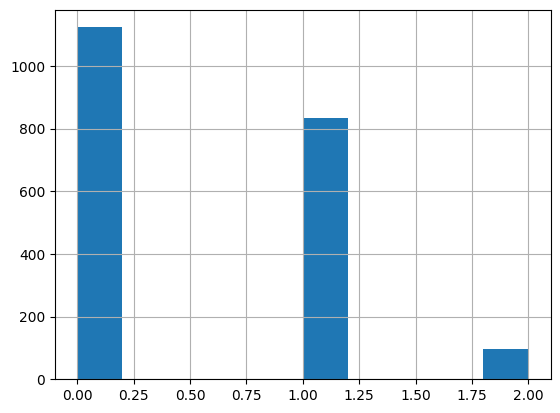

In [15]:
df_mod.label.hist()

In [16]:
df_mod.head()

,Review,label
0,কিছু পৃষ্ঠা ফাঁকা,0
1,প্রত্যাশার নীচে কাগজের গুণমান,0
2,সোলেমানীয়া বুক হাউস প্রকাশনীর সব বই গুলিতে প্র...,0
3,"বইয়ের কাভার আর সূচিপত্র প্রিয়গল্প-২, ভিতরে প্র...",0
4,"কালার , পেজ, লেখার কুয়ালিটি খুবই নিম্ন মানের ,...",0


In [17]:
df_mod.columns = ['sentence','label']
df_mod.to_csv('data.csv',index=None)

In [18]:
from datasets import load_dataset
raw_dataset = load_dataset('csv',data_files='data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [19]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2053
    })
})

In [20]:
split = raw_dataset['train'].train_test_split(test_size=0.2,seed=42)

In [21]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1642
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 411
    })
})

In [22]:
checkpoint = 'distilbert-base-cased'

In [23]:
from transformers import AutoTokenizer

In [24]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [25]:
def tokenizer_fn(batch):
  return tokenizer(batch['sentence'],truncation=True)

In [26]:
tokenized_dataset = split.map(tokenizer_fn,batched=True)

Map:   0%|          | 0/1642 [00:00<?, ? examples/s]

Map:   0%|          | 0/411 [00:00<?, ? examples/s]